# Rainfall products obtained from GEE

### Import libraries

In [1]:
import pandas as pd
import time
import numpy as np
import os
from tqdm import tqdm
import ee
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
from scipy import stats
from scipy.stats import pearsonr
import time
import cartopy.crs as ccrs
import geopandas
import cartopy.io.img_tiles as cimgt
os.environ['PROJ_LIB'] = 'C:/Users/owner/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore")

stamen_terrain = cimgt.Stamen('terrain-background')
ll_proj = ccrs.PlateCarree()

ee.Initialize()

### Functions

In [2]:
def plot_station(station, comparison, nice_map = False):
    if nice_map:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1, projection=ll_proj)
        m=Basemap()
        m.etopo(scale=0.5, alpha=0.5)
        m.shadedrelief()
        m.drawcoastlines(0.75)
        parallels = np.arange(-90.,91.,15.)
        m.drawparallels(parallels,labels=[False,True,True,False])
        meridians = np.arange(-180.,181.,25.)
        m.drawmeridians(meridians,labels=[True,False,False,True])
        ax.scatter(station[0], station[1], marker = '^', color = 'red', s = 100, zorder = 100)
        ax.set_extent([-180, 180, -90, 90])
        plt.show();
    else:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1, projection=ll_proj)
        ax.coastlines()
        ax.scatter(station[0], station[1], marker = '^', color = 'red', s = 100, zorder = 100)
        ax.set_extent([-180, 180, -90, 90])
        plt.show();
    print(comparison)

def GEE(date_start, date_stop, image_coll, patch, band2): 
    im_coll = dataset = ee.ImageCollection(image_coll).filterDate(ee.Date(date_start),ee.Date(date_stop)).select(band2)

    acq_times = im_coll.aggregate_array('system:time_start').getInfo()
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
    im_list = im_coll.toList(im_coll.size())
    
    variable_list = ee.List([])
   
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, variable_list)
    
    reduced_dataset_dict = reduced_dataset.getInfo()
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2]).dropna()
    df1.index = pd.to_datetime(df1.index)
    return df1

def rain_gee(point, date_start, date_stop):
    print('GPM Obtaining...')
    image_coll = "NASA/GPM_L3/IMERG_MONTHLY_V06"
    band2 = 'precipitation'

    GPM = GEE(date_start, date_stop, image_coll, point, band2)

    print('CHIRPS Obtaining...')
    image_coll = 'UCSB-CHG/CHIRPS/PENTAD'
    band2 = 'precipitation'

    CHIRPS = GEE(date_start, date_stop, image_coll, point, band2)

    print('ECMWF Obtaining...')
    image_coll = "ECMWF/ERA5/MONTHLY"
    band2 = 'total_precipitation'

    ECMWF = GEE(date_start, date_stop, image_coll, point, band2)

    print('TRMM Obtaining...')
    image_coll = "TRMM/3B43V7"
    band2 = 'precipitation'

    TRMM = GEE(date_start, date_stop, image_coll, point, band2)

    print('PERSIANN Obtaining...')
    image_coll = "NOAA/PERSIANN-CDR"
    band2 = 'precipitation'

    PERSIANN = GEE(date_start, date_stop, image_coll, point, band2)

    print('DONE..')

    GPM_r = GPM.resample('M').sum() * 24 * 30
    TRMM_r = TRMM.resample('M').sum() * 24 * 30
    ECMWF_r = ECMWF.resample('M').sum() * 24 * 30
    CHIRPS_r = CHIRPS.resample('M').sum()
    PERSIANN_r = PERSIANN.resample('M').sum()

    comparison = pd.concat([GPM_r, TRMM_r, ECMWF_r, CHIRPS_r, PERSIANN_r], 1)
    comparison.columns = ['GPM', 'TRMM', 'ECMWF', 'CHRIPS', 'PERSIANN']
    return comparison

### Merge the monthly rainfall products over the given point

GPM Obtaining...
CHIRPS Obtaining...
ECMWF Obtaining...
TRMM Obtaining...
PERSIANN Obtaining...
DONE..
--- 20.65s seconds ---


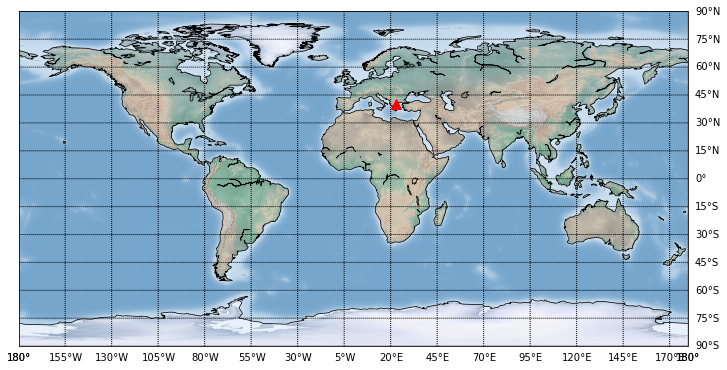

                   GPM        TRMM       ECMWF CHRIPS    PERSIANN
2015-01-31  102.447091   63.963116   28.826934    NaN   93.049875
2015-02-28  162.693379   71.243339   57.926788    NaN   90.052365
2015-03-31  175.697447  136.046566  110.770748    NaN  129.344251
2015-04-30    3.919172   22.758299    7.441472    NaN   38.780866
2015-05-31   41.430307   20.857860    6.378509    NaN   30.618561
...                ...         ...         ...    ...         ...
2020-08-31   30.728360         NaN         NaN    NaN   46.513442
2020-09-30   38.518074         NaN         NaN    NaN   36.707779
2020-10-31  108.672509         NaN         NaN    NaN   51.962917
2020-11-30   30.606668         NaN         NaN    NaN   14.340010
2020-12-31  288.013802         NaN         NaN    NaN  140.704307

[72 rows x 5 columns]


In [3]:
date_start = '2015-01-01'
date_stop = '2020-12-31'
station = [23, 40]
start_time = time.time()

comparison = rain_gee(ee.Geometry.Point(list(station)), date_start, date_stop)
print("--- %.2fs seconds ---" % (time.time() - start_time))

plot_station(station, comparison, nice_map = False)